In [ ]:
%%capture
# 한글 폰트 설치 및 리눅스 시스템 캐시 업데이트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# 폰트 적용 (실행 후 '런타임 다시 시작'이 필요할 수 있습니다)
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

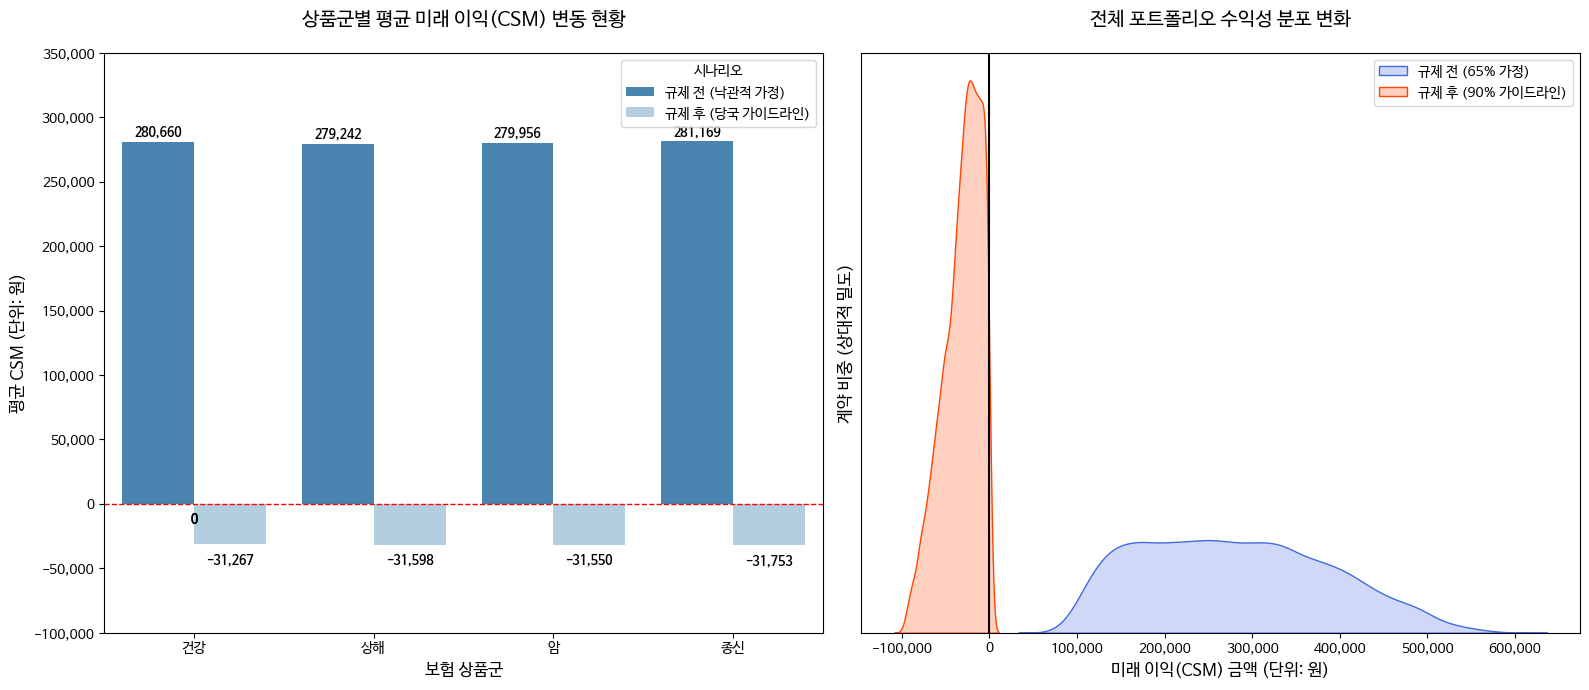

■ 분석 결과: 규제 도입 시 전체 CSM 감소액은 3,118,014,271원입니다.
■ 손실부담계약 비중: 규제 후 100.0%로 급증했습니다.


In [9]:
# 1. 데이터 로드 및 한글 매핑
df = pd.read_csv('insurance_sim_data.csv')

product_map = {'건강보험': '건강', '상해보험': '상해', '암보험': '암', '종신보험': '종신'}
df['상품군'] = df['Product_Type'].map(product_map)

# 2. 시각화 (1x2 Layout)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- [그래프 1] 상품군별 평균 미래 이익(CSM) 변동 ---
avg_csm = df.groupby('상품군')[['CSM_Old', 'CSM_New']].mean().reset_index()
avg_csm.columns = ['보험 상품군', '규제 전 (낙관적 가정)', '규제 후 (당국 가이드라인)']
avg_csm_melted = avg_csm.melt(id_vars='보험 상품군', var_name='시나리오', value_name='평균 CSM')

ax1 = sns.barplot(ax=axes[0], data=avg_csm_melted, x='보험 상품군', y='평균 CSM', hue='시나리오', palette='Blues_r')
axes[0].set_title('상품군별 평균 미래 이익(CSM) 변동 현황', fontsize=14, pad=20)
axes[0].set_xlabel('보험 상품군', fontsize=12)
axes[0].set_ylabel('평균 CSM (단위: 원)', fontsize=12)

# Y축 콤마 포맷팅 및 범위 설정
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[0].set_ylim(-100000, 350000)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)

# [추가] 막대 위에 수치 라벨링 (콤마 포함)
for p in ax1.patches:
    val = p.get_height()
    if not np.isnan(val):
        # 양수는 위쪽에, 음수는 아래쪽에 표시되도록 위치 조정
        y_pos = val + 5000 if val > 0 else val - 15000
        ax1.text(p.get_x() + p.get_width()/2., y_pos,
                f'{val:,.0f}', ha="center", fontsize=9, fontweight='bold')

# --- [그래프 2] 전체 포트폴리오 수익성 분포 변화 (KDE Plot) ---
sns.kdeplot(ax=axes[1], data=df['CSM_Old'], label='규제 전 (65% 가정)', fill=True, color='royalblue')
sns.kdeplot(ax=axes[1], data=df['CSM_New'], label='규제 후 (90% 가이드라인)', fill=True, color='orangered')
axes[1].axvline(0, color='black', linestyle='-', linewidth=1.5)

axes[1].set_title('전체 포트폴리오 수익성 분포 변화', fontsize=14, pad=20)
axes[1].set_xlabel('미래 이익(CSM) 금액 (단위: 원)', fontsize=12)
axes[1].set_ylabel('계약 비중 (상대적 밀도)', fontsize=12)

axes[1].set_yticks([])
axes[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].legend()

plt.tight_layout()
plt.show()

# 3. 주요 지표 요약
total_drop = df['CSM_Old'].sum() - df['CSM_New'].sum()
print(f"■ 분석 결과: 규제 도입 시 전체 CSM 감소액은 {total_drop:,.0f}원입니다.")
print(f"■ 손실부담계약 비중: 규제 후 {df['CSM_New'].apply(lambda x: x < 0).mean()*100:.1f}%로 급증했습니다.")